In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [40]:
import zipfile

with zipfile.ZipFile('/content/40xhighdensity.zip','r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
import numpy as np
import matplotlib
import shutil
import glob
import os
import math
!pip install sciPY
import scipy
!pip install matplotlib
import numpy as np
import matplotlib
import shutil
import glob
import os
import math
!pip install Pillow
!pip install tensorflow
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
#from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential  # Assuming TensorFlow 2.0+
import keras
!pip install keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!pip install keras-preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2
import PIL.Image
from tensorflow.keras.preprocessing.image import load_img


In [4]:
! pip install --upgrade pip
!pip install --upgrade Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 53.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 53.5 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 10.4.0
    Uninstalling pillow-10.4.0:
      Successfully uninstalled pillow-10.4.0


In [41]:
#count number of images and classes Benign=0 maligant=1
ROOT_DIR="/content/40xhighdensity"
number_of_images={}
for dir in os.listdir(ROOT_DIR):
       number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))
       number_of_images.items()

In [42]:
number_of_images.items()

dict_items([('Maligant', 1223), ('Benign', 1548)])

In [43]:
# Count the number of images in each class
for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

# Split the dataset: 70% training, 15% testing, and 15% validation
if not os.path.exists("./train400h"):
    os.mkdir("./train400h")
    os.mkdir("./test400h")
    os.mkdir("./validation400h")

    for dir in os.listdir(ROOT_DIR):
        os.makedirs("./train400h/" + dir)
        os.makedirs("./test400h/" + dir)
        os.makedirs("./validation400h/" + dir)
        # Calculate the number of images for each split
        train_size = math.floor(0.7 * number_of_images[dir])
        test_size = math.floor(0.15 * number_of_images[dir])
        validation_size = number_of_images[dir] - train_size - test_size

        # Get a random sample of images for each split
        all_images = os.listdir(os.path.join(ROOT_DIR, dir))
        train_images = np.random.choice(all_images, size=train_size, replace=False)
        remaining_images = list(set(all_images) - set(train_images))
        test_images = np.random.choice(remaining_images, size=test_size, replace=False)
        validation_images = list(set(remaining_images) - set(test_images))

        # Move images to the appropriate folders
        for img in train_images:
            source_path = os.path.join(ROOT_DIR, dir, img)
            destination_path = os.path.join("./train400h", dir, img)
            shutil.copy(source_path, destination_path)
            os.remove(source_path)

        for img in test_images:
            source_path = os.path.join(ROOT_DIR, dir, img)
            destination_path = os.path.join("./test400h", dir, img)
            shutil.copy(source_path, destination_path)
            os.remove(source_path)

        for img in validation_images:
            source_path = os.path.join(ROOT_DIR, dir, img)
            destination_path = os.path.join("./validation400h", dir, img)
            shutil.copy(source_path, destination_path)
            os.remove(source_path)
else:
    print("The folders already exist.")


In [44]:
# Count the number of images in the validation folder
number_of_images_val = {}
for dir in os.listdir("./validation400h"):
    number_of_images_val[dir] = len(os.listdir(os.path.join("./validation400h", dir)))

number_of_images_val

{'Maligant': 184, 'Benign': 233}

In [45]:
# Count the number of images in the training folder
number_of_images_train = {}
for dir in os.listdir("./train400h"):
    number_of_images_train[dir] = len(os.listdir(os.path.join("./train400h", dir)))

number_of_images_train

{'Maligant': 856, 'Benign': 1083}

In [46]:
# Count the number of images in the test folder
number_of_images_test = {}
for dir in os.listdir("./test400h"):
    number_of_images_test[dir] = len(os.listdir(os.path.join("./test400h", dir)))

number_of_images_test

{'Maligant': 183, 'Benign': 232}

In [47]:
import tensorflow as tf  # Assuming you're using TensorFlow with Keras

# Define your data directories
train_path = "train400h"
validation_path = "validation400h"  # Clear name for validation set
#test_path = "test400"               # Separate directory for testing

# Set up data generators for training, validation, and testing

def preprocessing_images(path, target_size=(224, 224), batch_size=32, class_mode='categorical'):
  """
  Preprocesses images using ImageDataGenerator and returns a data generator.

  Args:
      path: Path to the directory containing images.
      target_size: Target size (width, height) to resize the images.
      batch_size: Batch size for training the model.
      class_mode: Mode for classifying images ('binary' for 2 classes,
                   'categorical' for more than 2 classes).

  Returns:
      A Keras ImageDataGenerator object representing the preprocessed dataset.
  """

  image_data = ImageDataGenerator(
      rescale=1/255,  # Normalize pixel values to [0, 1]
      zoom_range=0.1,  # Randomly zoom images by up to 10%
      shear_range=0.2,  # Randomly shear images by up to 20 degrees
      rotation_range=20,  # Randomly rotate images by up to 20 degrees
      horizontal_flip=True,  # Randomly flip images horizontally
      vertical_flip=True   # Randomly flip images vertically
  )

  # Use flow_from_directory to create data generators
  image_generator = image_data.flow_from_directory(
      directory=path,
      target_size=target_size,
      batch_size=batch_size,
      class_mode=class_mode
  )

  return image_generator



# Create training, validation, and test data generators
train_data = preprocessing_images(train_path)
val_data = preprocessing_images(validation_path)
#test_data = preprocessing_images(test_path)  # Create a separate generator for testing

# Build your image classification model (code not provided)

# Train your model using train_data and val_data for validation

# Evaluate your model's performance on the test set using test_data

# (Code for building, training, and evaluating the model is not provided)

Found 1939 images belonging to 2 classes.
Found 417 images belonging to 2 classes.


In [48]:
#Define your data directories
train_path = "train400h"
#test_path = "test400m"

# Set up data generators for training and validation
def preprocessingImages(path):
    # Apply data augmentation (rotation and flip)
    image_data = ImageDataGenerator(
        rescale=1/255,
        zoom_range=0.1,
        shear_range=0.2,
        rotation_range=20,  # Rotate images randomly up to 20 degrees
        horizontal_flip=True,  # Flip images horizontally
        vertical_flip=True  # Flip images vertically
    )
    image = image_data.flow_from_directory(directory=path, target_size=(224, 224), batch_size=32, class_mode='categorical')
    return image

train_data = preprocessingImages(train_path)
#test_data = preprocessingImages(test_path)
val_data = preprocessingImages(validation_path)  # Create validation data similarly to training data

Found 1939 images belonging to 2 classes.
Found 417 images belonging to 2 classes.


In [49]:
#Define your data directories
train_path = "train400h"
#test_path = "test400"

# Set up data generators for training and validation
def preprocessingImages(path):
    # Apply data augmentation (rotation and flip)
    image_data = ImageDataGenerator(
        rescale=1/255,
        zoom_range=0.1,
        shear_range=0.2,
        rotation_range=20,  # Rotate images randomly up to 20 degrees
        horizontal_flip=True,  # Flip images horizontally
        vertical_flip=True  # Flip images vertically
    )
    image = image_data.flow_from_directory(directory=path, target_size=(224, 224), batch_size=40, class_mode='categorical')
    return image

train_data = preprocessingImages(train_path)
val_data = preprocessingImages(validation_path)  # Create validation data similarly to training data

print("Data generators for training and validation (with data augmentation) created successfully!")

Found 1939 images belonging to 2 classes.
Found 417 images belonging to 2 classes.
Data generators for training and validation (with data augmentation) created successfully!


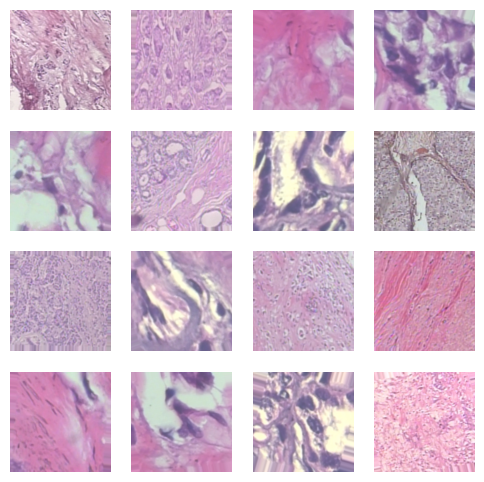

Total augmented images: 1568


In [50]:
# Assuming you have already imported necessary libraries (e.g., ImageDataGenerator, matplotlib)
import matplotlib.pyplot as plt

# Generate augmented images
augmented_images = next(train_data)  # Get a batch of augmented images

# Display a few augmented images
fig, axs = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axs.flat):
    if i < len(augmented_images[0]):  # Check if index is within bounds
        ax.imshow(augmented_images[0][i])
        ax.axis('off')
plt.show()

num_batches = len(train_data)  # Number of batches
batch_size = 32  # Your specified batch size
total_augmented_images = num_batches * batch_size
print(f"Total augmented images: {total_augmented_images}")

In [58]:
! pip install tensorflow
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
#from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential  # Assuming TensorFlow 2.0+
import keras
!pip install keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!pip install keras-preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2


In [61]:

# Import necessary libraries from TensorFlow's Keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l1, l2
import PIL.Image

import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten,Dense
from keras.models import Model,load_model
from keras.applications.mobilenet import MobileNet
base_model=MobileNet(input_shape=(224,224,3),include_top=False)
X=Flatten()(base_model.output)
X=Dense(units=2,activation ='softmax')(X)
model=Model(base_model.input,X)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5144 - loss: 1.4259 - val_accuracy: 0.6475 - val_loss: 0.8892 - learning_rate: 1.0000e-05 - lr: 1.0000e-05
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.6863 - loss: 0.9754

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6969 - loss: 0.9350 - val_accuracy: 0.9412 - val_loss: 0.4896 - learning_rate: 4.2000e-05 - lr: 4.2000e-05
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9048 - loss: 0.2364 - val_accuracy: 0.8125 - val_loss: 0.5189 - learning_rate: 3.5600e-05 - lr: 3.5600e-05
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.9635 - loss: 0.0751 - val_accuracy: 0.8235 - val_loss: 0.3242 - learning_rate: 3.0480e-05 - lr: 3.0480e-05
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9668 - loss: 0.0693 - val_accuracy: 0.8650 - val_loss: 0.3571 - learning_rate: 2.6384e-05 - lr: 2.6384e-05
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9869 - loss: 0.0343 - val_accuracy: 0.8235 - val_loss: 0.3650 - learning_rate: 2.3107e-05 - lr: 2.3107e-05
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9860 - loss: 0.0229 - val_accuracy: 0.9050 - val_loss: 0.2937 - learning_rate: 2.0486e-05 - lr: 2.0486e

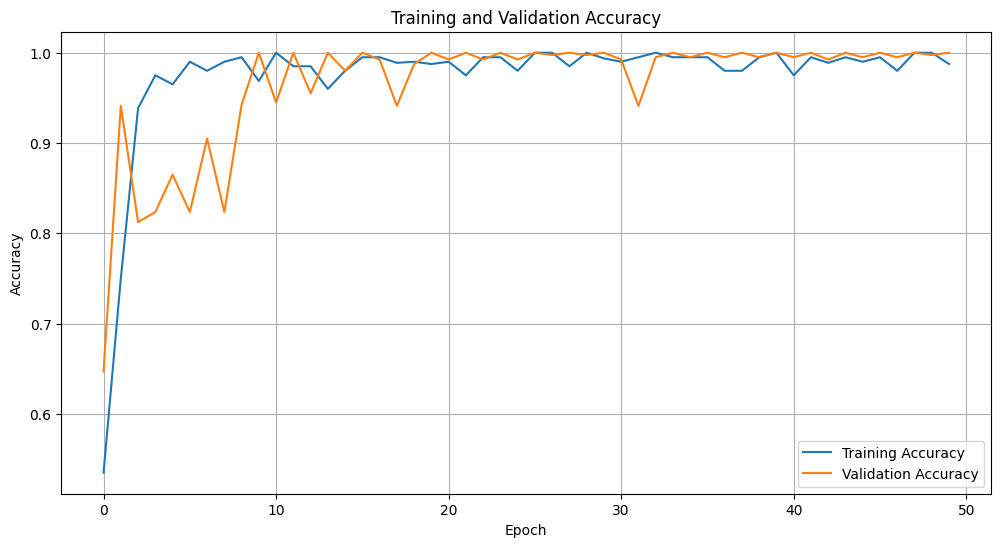

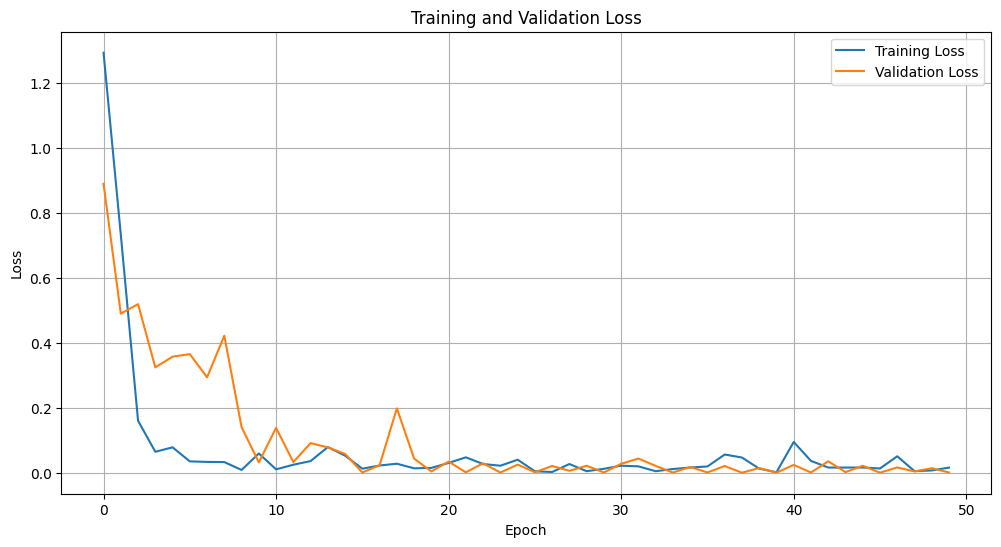

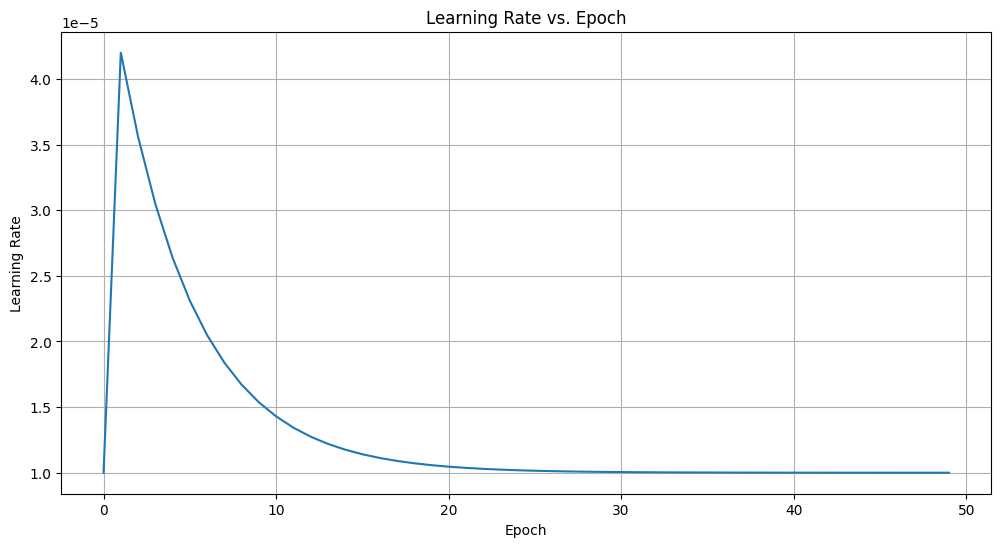

In [62]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
import tensorflow as tf

# Define learning rate schedules (final)
def lr_schedule(epoch, lr_warmup_epochs=25, lr_min=1e-5, lr_max=5e-5, lr_exp_decay=0.8):
    """
    Defines a learning rate schedule with warmup and exponential decay.

    Args:
        epoch (int): Current training epoch.
        lr_warmup_epochs (int, optional): Number of epochs for warmup. Defaults to 25.
        lr_min (float, optional): Minimum learning rate. Defaults to 1e-5.
        lr_max (float, optional): Maximum learning rate. Defaults to 5e-5.
        lr_exp_decay (float, optional): Learning rate exponential decay factor. Defaults to 0.8.

    Returns:
        float: The learning rate for the current epoch.
    """
    lr_start = lr_min
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

# Define a custom callback to log learning rates
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Corrected attribute for accessing learning rate in TensorFlow 2.x
        logs['lr'] = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

# Compile the model (assuming you have defined it and set the optimizer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create the LearningRateScheduler object with the defined function
learning_rate_scheduler = LearningRateScheduler(lr_schedule)

# Define the model checkpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Add learning rate logger
lr_logger = LearningRateLogger()

# Fit the model with learning rate scheduler, checkpoint, and logger
history = model.fit(
    train_data,
    steps_per_epoch=5,
    epochs=50,
    verbose=1,
    validation_data=val_data,
    validation_steps=10,
    callbacks=[learning_rate_scheduler, checkpoint, lr_logger]  # Adding both scheduler and checkpoint
)

# Plot Training & Validation Accuracy Graph
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Training & Validation Loss Graph
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot Learning Rate vs Epoch
# Ensure 'lr' is in the history object
if 'lr' in history.history:
    learning_rates = history.history['lr']
    epochs = range(len(learning_rates))
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, learning_rates)
    plt.title('Learning Rate vs. Epoch')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.show()


Found 415 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step

Confusion Matrix:
[[218  14]
 [  0 183]]

Test Accuracy: 0.97

Precision: 0.97
Recall: 0.97
F1-Score: 0.97
AUC: 1.00


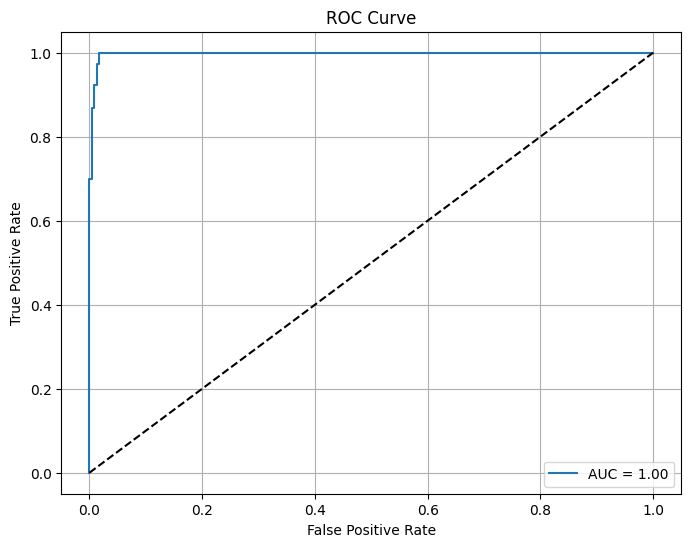

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the best saved model
best_model = load_model('best_model.keras')

# Test data directory (replace with your actual path)
test_data_dir = 'test400h'

# Image dimensions (replace with your image dimensions used during training)
img_height = 224
img_width = 224
batch_size = 32  # Adjust batch size as needed

# Preprocess test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generator for test images
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # Assuming multi-class classification (modify as per your case)
    shuffle=False  # Important to set shuffle to False for correct prediction alignment
)

# Make predictions on test data
predictions = best_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)

# Get predicted class indices (argmax) for multi-class or binary
predicted_classes = np.argmax(predictions, axis=1)

# Ground truth labels
true_classes = test_generator.classes

# Class labels (modify this if you have more than two classes)
class_labels = list(test_generator.class_indices.keys())  # Get class labels from generator

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(cm)

# Test Accuracy
test_accuracy = accuracy_score(true_classes, predicted_classes)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

# Precision, Recall, and F1-Score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# AUC-ROC Curve (for binary or multi-class)
# If binary classification, calculate AUC directly
if len(class_labels) == 2:
    # For binary classification, roc_auc_score expects the probabilities for the positive class
    auc_score = roc_auc_score(true_classes, predictions[:, 1])
    print(f"AUC: {auc_score:.2f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_classes, predictions[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

else:
    # For multi-class classification, use one-vs-rest strategy
    auc_score = roc_auc_score(true_classes, predictions, multi_class='ovr')
    print(f"AUC: {auc_score:.2f}")

    # Plot ROC curve for each class
    for i, label in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(true_classes == i, predictions[:, i])
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(true_classes == i, predictions[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



Found 415 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step

Confusion Matrix:
[[218  14]
 [  0 183]]


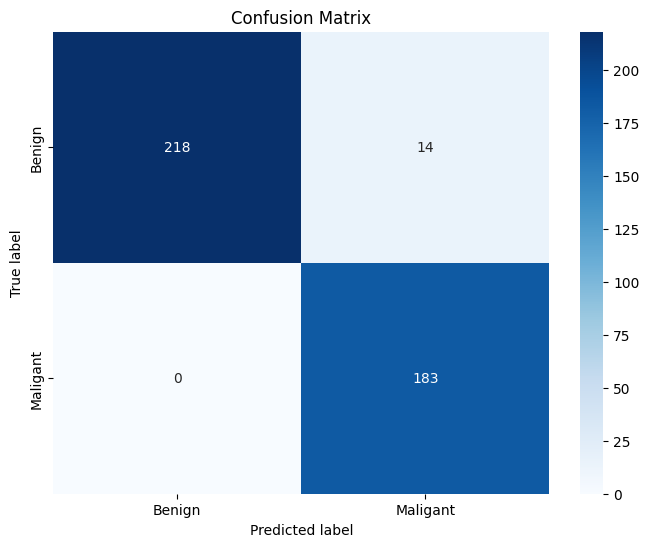


Test Accuracy: 0.97

Precision: 0.97
Recall: 0.97
F1-Score: 0.97
AUC: 1.00


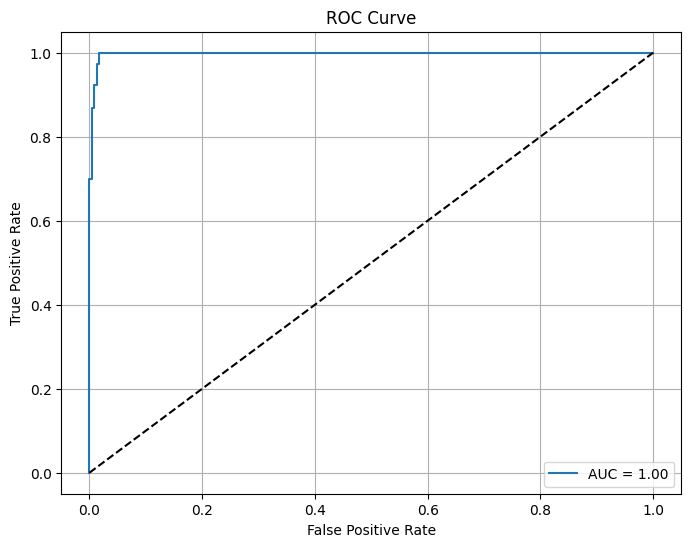

In [65]:


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the best saved model
best_model = load_model('best_model.keras')

# Test data directory (replace with your actual path)
test_data_dir = 'test400h'

# Image dimensions (replace with your image dimensions used during training)
img_height = 224
img_width = 224
batch_size = 32  # Adjust batch size as needed

# Preprocess test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generator for test images
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # Assuming binary classification
    shuffle=False  # Important to set shuffle to False for correct prediction alignment
)

# Make predictions on test data
predictions = best_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)

# Get predicted class indices (argmax) for binary classification
predicted_classes = np.argmax(predictions, axis=1)

# Ground truth labels
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())  # Get class labels from generator

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(cm)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Test Accuracy
test_accuracy = accuracy_score(true_classes, predicted_classes)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

# Precision, Recall, and F1-Score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# AUC-ROC Curve (for binary or multi-class)
if len(class_labels) == 2:
    # For binary classification
    auc_score = roc_auc_score(true_classes, predictions[:, 1])
    print(f"AUC: {auc_score:.2f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_classes, predictions[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
else:
    # For multi-class classification
    auc_score = roc_auc_score(true_classes, predictions, multi_class='ovr')
    print(f"AUC: {auc_score:.2f}")

    # Plot ROC curve for each class
    for i, label in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(true_classes == i, predictions[:, i])
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(true_classes == i, predictions[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

